# Capstone project

---

Car accident model - based on Data from the UK Department for Transport (2005-2014)

Data files provide detailed road safety data about the circumstances of personal injury road accidents in GB from 2005 to 2014:

- Accident file: main data set contains information about accident severity, weather, location, date, hour, day of week, road type…
- Vehicle file: contains information about vehicle type, vehicle model, engine size, driver sex, driver age, car age…
- Casualty file: contains information about casualty severity, age, sex social class, casualty type, pedestrian or car passenger…

---

# Introduction

Unfortunately, car accidents happen.

Would it be possible to understand/predict the severity of an eventual accident if ever happening?

Such a predictive model could be interesting for instance:

- For insurance companies to set a final price for an inssurance.
- For government authorities to forcast casualties that may occur during a year based on vehicles registered and drivers records an plan measures to reduce those casualties numbers.
- For generate awareness in individuals so that they are aware of the need of replacing their car, be even more careful when it rains or when it's a foggy day, etc.

We will be exploring the feasibility of creating such a predictive model based on variables that could be stored into the following catergories:

- Driver data (age, etc.)
- Time, road and environmental conditions (visibility, weather conditions, moment of the year, etc.)
- Car specifications (Engine capacity, driver side, etc)
- Parameters of the accident (speed, point of impact, etc.)

Based on those variables the model would predict if ever having an accident if it's going to be "fatal", "Serious" or "Slight" a certain probability (multiclass classification problem). We could also for simplicity, make the model to assist a binary classification model where based on the same variables we would be looking to predict between "fatal accidents" and "serious/slight" accidents.

To proceed we will be using the database published on Kaggle.com called "UK Accidents 10 years history with many variables" that collects accidents that took place from 2005-2014 in UK roads. Data are stored in 3 tables: accidents, vehicles and casualties and can be found in the following link: https://www.kaggle.com/benoit72/uk-accidents-10-years-history-with-many-variables

NOTE: this database is likely to give insights / prediction model to be used only for countries like UK, Japan, Australia, India (more that 50 countries) where traffic happens from left side.

---


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install scikit-learn
print('Scikit-learn lib Installed!')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import svm

Scikit-learn lib Installed!


### 0. Loading data

Loading data for each .csv data file available and dropping columns that wouldn't look as adequate or specially relevant to build a model.

In [104]:
df_accidents = pd.read_csv('Accidents0514.csv')

atrib_to_drop_df_accidents = ['Location_Easting_OSGR','Location_Northing_OSGR','Longitude','Latitude',
                             'Police_Force','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities',
                             'Special_Conditions_at_Site','Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident','LSOA_of_Accident_Location',
                             '1st_Road_Class','1st_Road_Number','Junction_Detail','Junction_Control','2nd_Road_Class','2nd_Road_Number',
                             'Number_of_Vehicles','Local_Authority_(District)','Local_Authority_(Highway)','Road_Type','Time','Number_of_Casualties',
                             'Weather_Conditions']

df_accidents.drop(columns = atrib_to_drop_df_accidents, inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
df_vehicles = pd.read_csv('Vehicles0514.csv')

atrib_to_drop_df_vehicles = ['Towing_and_Articulation','Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane','Junction_Location',
                            'Skidding_and_Overturning','Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway','Hit_Object_off_Carriageway',
                            'Driver_IMD_Decile','Driver_Home_Area_Type','Vehicle_Reference','Was_Vehicle_Left_Hand_Drive?','Journey_Purpose_of_Driver',
                            'Age_of_Driver','Propulsion_Code','Engine_Capacity_(CC)']

df_vehicles.drop(columns = atrib_to_drop_df_vehicles, inplace=True)

In [106]:
df_casualties = pd.read_csv('Casualties0514.csv')

atrib_to_drop_df_casualties = ['Casualty_Reference','Sex_of_Casualty','Age_of_Casualty','Age_Band_of_Casualty',
                               'Pedestrian_Location','Pedestrian_Movement','Bus_or_Coach_Passenger','Pedestrian_Road_Maintenance_Worker',
                               'Casualty_Home_Area_Type','Vehicle_Reference','Casualty_Class','Car_Passenger','Casualty_Type']

df_casualties.drop(columns = atrib_to_drop_df_casualties, inplace=True)

### 1. Data wrangling

In [107]:
# We join dataframes based on key column
df = df_vehicles.join(df_casualties.set_index('Accident_Index'), on='Accident_Index')
df = df.join(df_accidents.set_index('Accident_Index'), on='Accident_Index')

# According to the data 
df = df.replace(-1,np.NaN)
print(df.isna().sum())
df.dropna(axis=0,inplace=True)

Accident_Index                   0
Vehicle_Type                   554
1st_Point_of_Impact           2418
Sex_of_Driver                   46
Age_Band_of_Driver          405664
Age_of_Vehicle             1155488
Casualty_Severity                0
Accident_Severity                0
Date                             0
Day_of_Week                      0
Speed_limit                      0
Light_Conditions                 0
Road_Surface_Conditions       4824
Urban_or_Rural_Area              0
dtype: int64


In [108]:
print(df['Accident_Severity'].value_counts())

3    2469760
2     413143
1      61518
Name: Accident_Severity, dtype: int64


In [109]:
# In the data we have information for different kinds of vehicles, keeping only data for cares stored in value = 9
print(df['Vehicle_Type'].value_counts())

9.0     2399925
19.0     134424
5.0       82233
11.0      80927
8.0       55046
21.0      54278
3.0       53692
2.0       29212
4.0       21050
20.0      14939
10.0       6756
90.0       6651
17.0       5002
98.0        149
97.0        120
22.0         11
23.0          6
Name: Vehicle_Type, dtype: int64


In [110]:
# Only taking car, value = 9 according to tables
df_cars = df.loc[df['Vehicle_Type'] == 9]
df_cars.drop(columns = 'Vehicle_Type', inplace=True)
df_cars.head()

,Accident_Index,1st_Point_of_Impact,Sex_of_Driver,Age_Band_of_Driver,Age_of_Vehicle,Casualty_Severity,Accident_Severity,Date,Day_of_Week,Speed_limit,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
3,200501BS00003,3.0,1.0,9.0,6.0,3,3,06/01/2005,5,30,4,1.0,1
4,200501BS00004,1.0,2.0,8.0,4.0,3,3,07/01/2005,6,30,1,1.0,1
6,200501BS00006,0.0,1.0,8.0,1.0,3,3,11/01/2005,3,30,1,2.0,1
9,200501BS00007,2.0,1.0,7.0,4.0,3,3,13/01/2005,5,30,4,1.0,1
10,200501BS00009,1.0,1.0,10.0,16.0,3,3,14/01/2005,6,30,1,1.0,1


In [111]:
# Removing data values in this column that are set as not specified = 3
df_cars.drop(df_cars.loc[df_cars['Sex_of_Driver']==3].index, inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [112]:
# Keeping cars that are with an age below 30 (based on fq distribution, most data of the dataset will be conserved)
df_cars.drop(df_cars.loc[df_cars['Age_of_Vehicle'] > 30].index, inplace=True)

In [113]:
# if 0 there is some kind of darkness situation, if 1 daylight
df_cars['Light_Conditions'].replace({1:1 , 4:0 , 5:0, 6:0, 7:0}, inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [114]:
# We set new categories (simplified) => 1 = dry , 2 = wet , 3 = ice/snow related
df_cars['Road_Surface_Conditions'].replace({1:1 , 2:2 , 3:3, 4:3, 5:2}, inplace=True)

In [115]:
# Accident ID can be drop now
df_cars.drop(columns = 'Accident_Index', inplace=True)

In [116]:
# We see the types of data we have and later replace data type accordingly if needed
df_cars.dtypes

1st_Point_of_Impact        float64
Sex_of_Driver              float64
Age_Band_of_Driver         float64
Age_of_Vehicle             float64
Casualty_Severity            int64
Accident_Severity            int64
Date                        object
Day_of_Week                  int64
Speed_limit                  int64
Light_Conditions             int64
Road_Surface_Conditions    float64
Urban_or_Rural_Area          int64
dtype: object

In [117]:
# We replace data type float for int
df_cars.dropna(axis=0,inplace=True)
df_cars = df_cars.astype({'1st_Point_of_Impact': int, 
                          'Sex_of_Driver': int,
                          'Age_Band_of_Driver': int,
                          'Age_of_Vehicle': int,
                          'Road_Surface_Conditions': int})

C:\Users\Sergio\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
# Date is object, we make it datetime object in order to later extract month
df_cars['Date']= pd.to_datetime(df_cars['Date'])

# Extracting month from Date
df_cars['Month'] = df_cars['Date'].dt.month

# Droping Date now
df_cars.drop(columns = ['Date'], inplace=True)

In [119]:
# Arranging the order of the columns in the df_cars so that is easier to understand
df_cars = df_cars[['Age_Band_of_Driver','Sex_of_Driver',
                   'Age_of_Vehicle','Light_Conditions','Road_Surface_Conditions',
                   'Urban_or_Rural_Area','Day_of_Week','Month','1st_Point_of_Impact','Speed_limit','Casualty_Severity',
                   'Accident_Severity']]

In [120]:
# In case some rows would be duplicated we remove them
df_cars = df_cars.drop_duplicates()

In [121]:
# Accident_Severity and Casualty_Severity should be equal, checking to see if we can remove one of the columns
print(df_cars['Accident_Severity'].equals(df_cars['Casualty_Severity']))

False


In [122]:
# Accident_Severity and Casualty_Severity are not equal according to analysis, therefore need to remove those rows do not have equal values for those columns
df_cars.drop(df_cars.index[df_cars['Accident_Severity'] != df_cars['Casualty_Severity']], inplace = True)
df_cars.drop(columns = ['Casualty_Severity'], inplace=True)
print(df_cars['Accident_Severity'].value_counts())

3    708523
2     93002
1      7610
Name: Accident_Severity, dtype: int64


In [123]:
# Reseting indexes and visualizing final df_cars
df_cars.reset_index(drop=True).head()

# We save the final dataset cars.csv
df_cars.to_csv('cars.csv',index=False)

### 2. Data Analysis

In [124]:
# Visualizing the final df_cars
df_cars = pd.read_csv('cars.csv')
df_cars.head()

,Age_Band_of_Driver,Sex_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Month,1st_Point_of_Impact,Speed_limit,Accident_Severity
0,9,1,6,0,1,1,5,6,3,30,3
1,8,2,4,1,1,1,6,7,1,30,3
2,8,1,1,1,2,1,3,11,0,30,3
3,7,1,4,0,1,1,5,1,2,30,3
4,10,1,16,1,1,1,6,1,1,30,3


In [125]:
# We prove that the variables conserved have an interesting correlation with the outcome of the accident = severity
# Note that Age_Band_of_Driver and Age_of_vehicle have a significant negative correlation with Accident_Severity
# Note also that Sex_of_Driver and Light_Conditions have a significant positive impact in the Accident_Severity
df_cars.corr()

,Age_Band_of_Driver,Sex_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Month,1st_Point_of_Impact,Speed_limit,Accident_Severity
Age_Band_of_Driver,1.000000,-0.039053,-0.052373,0.128171,-0.058627,-0.010523,0.004666,0.006886,0.007731,-0.038900,-0.018924
Sex_of_Driver,-0.039053,1.000000,-0.068005,0.075983,0.003147,-0.007172,0.001114,-0.000074,0.012925,-0.021697,0.050586
Age_of_Vehicle,-0.052373,-0.068005,1.000000,0.000734,-0.015993,-0.030965,0.002975,-0.007275,-0.027582,-0.055071,0.007477
Light_Conditions,0.128171,0.075983,0.000734,1.000000,-0.127609,0.061716,-0.007152,-0.035643,0.024299,0.025685,0.020454
Road_Surface_Conditions,-0.058627,0.003147,-0.015993,-0.127609,1.000000,0.043077,-0.005593,0.043678,-0.049309,0.042093,0.059870
Urban_or_Rural_Area,-0.010523,-0.007172,-0.030965,0.061716,0.043077,1.000000,-0.004530,0.002986,-0.071309,0.547173,0.031530
Day_of_Week,0.004666,0.001114,0.002975,-0.007152,-0.005593,-0.004530,1.000000,0.000507,0.002095,-0.005977,-0.003270
Month,0.006886,-0.000074,-0.007275,-0.035643,0.043678,0.002986,0.000507,1.000000,-0.001602,0.003408,-0.000796
1st_Point_of_Impact,0.007731,0.012925,-0.027582,0.024299,-0.049309,-0.071309,0.002095,-0.001602,1.000000,-0.064987,0.023439
Speed_limit,-0.038900,-0.021697,-0.055071,0.025685,0.042093,0.547173,-0.005977,0.003408,-0.064987,1.000000,0.040120


We need now to analyze the selected variables vs Accident_Severity to decide thresholding and improve categorization of the data

#### 2.0. Accdent_Severity

In [126]:
# We verify the distribution we have for Accident_Severity
print(df_cars['Accident_Severity'].value_counts())

3    708523
2     93002
1      7610
Name: Accident_Severity, dtype: int64


#### 2.1. Age_Band_of_Driver

In [127]:
x = df_cars['Accident_Severity'].values
y = df_cars['Age_Band_of_Driver'].values

(array([3.00000e+00, 1.00000e+01, 3.45000e+02, 9.85790e+04, 1.15612e+05,
        1.56185e+05, 1.46305e+05, 1.20545e+05, 8.51130e+04, 8.64380e+04]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

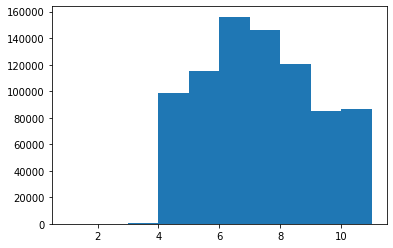

In [128]:
#plt.subplot(121)
plt.hist(df_cars['Age_Band_of_Driver'])

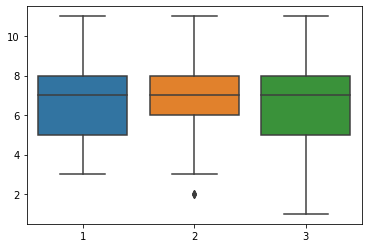

In [129]:
sns.boxplot(x=x, y=y)

In [130]:
df_cars.groupby(['Accident_Severity','Age_Band_of_Driver']).size()

Accident_Severity  Age_Band_of_Driver
1                  3                          7
                   4                        869
                   5                       1115
                   6                       1541
                   7                       1288
                   8                       1076
                   9                        737
                   10                       493
                   11                       484
2                  2                          3
                   3                         39
                   4                       9902
                   5                      12523
                   6                      18297
                   7                      17197
                   8                      14144
                   9                      10017
                   10                      6091
                   11                      4789
3                  1                          3
  

In [131]:
df_cars['Age_Band_of_Driver'].replace({1:0 , 2:0 , 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:2, 11:2}, inplace=True)

#### 2.2. Sex_of_Driver

In [132]:
y = df_cars['Sex_of_Driver'].values

In [133]:
df_cars.groupby(['Accident_Severity','Sex_of_Driver']).size()

Accident_Severity  Sex_of_Driver
1                  1                  5686
                   2                  1924
2                  1                 59228
                   2                 33774
3                  1                407581
                   2                300942
dtype: int64

#### 2.4. Age_of_Vehicle

(array([170426., 177871., 179832., 153373.,  84966.,  30086.,   8492.,
          2691.,    970.,    428.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 10 Patch objects>)

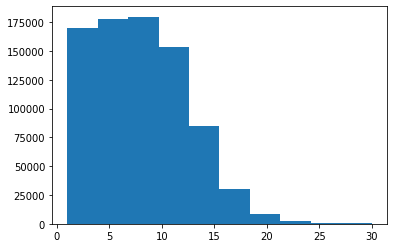

In [134]:
plt.hist(df_cars['Age_of_Vehicle'])

In [135]:
y = df_cars['Age_of_Vehicle'].values

In [136]:
df_cars.groupby(['Accident_Severity','Age_of_Vehicle']).size()

Accident_Severity  Age_of_Vehicle
1                  1                 521
                   2                 498
                   3                 507
                   4                 545
                   5                 544
                                    ... 
3                  26                248
                   27                204
                   28                163
                   29                127
                   30                 93
Length: 88, dtype: int64

In [137]:
df_cars['Age_of_Vehicle'].replace({1:0 , 2:0 , 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0,
                                 11:0, 12:0, 13:0, 14:0, 15:0, 16:1, 17:1, 18:1, 19:1, 20:1,
                                  21:1, 22:1, 23:1, 24:1, 25:1, 26:1, 27:1, 28:1, 29:1, 30:1}, inplace=True)

In [138]:
df_cars.groupby(['Accident_Severity','Age_of_Vehicle']).size()

Accident_Severity  Age_of_Vehicle
1                  0                   7268
                   1                    342
2                  0                  88870
                   1                   4132
3                  0                 670330
                   1                  38193
dtype: int64

#### 2.5. Urban or rural area

In [139]:
df_cars['Urban_or_Rural_Area'].value_counts()

2    405485
1    403550
3       100
Name: Urban_or_Rural_Area, dtype: int64

We will group big cities accidents in 0 and the rest small cities and rural in 1

In [140]:
df_cars['Urban_or_Rural_Area'].replace({1:0 , 2:1, 3:1}, inplace=True)

#### 2.6. Day of the week

In [141]:
df_cars['Day_of_Week'].value_counts()

6    127781
4    119215
5    118679
3    117875
2    114413
7    111415
1     99757
Name: Day_of_Week, dtype: int64

In [142]:
df_cars.groupby(['Accident_Severity','Day_of_Week']).size()

Accident_Severity  Day_of_Week
1                  1                1236
                   2                 937
                   3                 950
                   4                 982
                   5                 995
                   6                1176
                   7                1334
2                  1               11649
                   2               12839
                   3               13500
                   4               13409
                   5               13660
                   6               14742
                   7               13203
3                  1               86872
                   2              100637
                   3              103425
                   4              104824
                   5              104024
                   6              111863
                   7               96878
dtype: int64

In [143]:
df_cars['Day_of_Week'].replace({1:0 , 2:1 , 3:1, 4:1, 5:1, 6:0, 7:0}, inplace=True)

#### 2.7. Month

In [144]:
df_cars['Month'].value_counts()

11    75906
1     75002
12    72793
10    70708
9     65415
2     65091
3     65001
8     64922
5     64789
7     64154
6     63231
4     62123
Name: Month, dtype: int64

In [145]:
df_cars.groupby(['Accident_Severity','Month']).size()

Accident_Severity  Month
1                  1          671
                   2          591
                   3          616
                   4          547
                   5          604
                   6          555
                   7          634
                   8          605
                   9          662
                   10         713
                   11         710
                   12         702
2                  1         8182
                   2         7075
                   3         7451
                   4         7325
                   5         7754
                   6         7688
                   7         7695
                   8         7596
                   9         7981
                   10        8365
                   11        8330
                   12        7560
3                  1        66149
                   2        57425
                   3        56934
                   4        54251
                   5   

In [146]:
df_cars['Month'].replace({1:1 , 2:1 , 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1}, inplace=True)

#### 2.8. Point of impact

In [147]:
df_cars['1st_Point_of_Impact'].value_counts()

1    337100
2    178609
3    135209
4    116588
0     41629
Name: 1st_Point_of_Impact, dtype: int64

In [148]:
df_cars.groupby(['Accident_Severity','1st_Point_of_Impact']).size()

Accident_Severity  1st_Point_of_Impact
1                  0                         649
                   1                        4462
                   2                         398
                   3                        1172
                   4                         929
2                  0                        5146
                   1                       46465
                   2                        9403
                   3                       16832
                   4                       15156
3                  0                       35834
                   1                      286173
                   2                      168808
                   3                      117205
                   4                      100503
dtype: int64

In [149]:
df_cars['1st_Point_of_Impact'].replace({0:0, 1:1 , 2:1, 3:1, 4:1}, inplace=True)

#### 2.9. Speed limit

In [150]:
df_cars.groupby(['Accident_Severity','Speed_limit']).size()

Accident_Severity  Speed_limit
1                  10                  1
                   20                 36
                   30               2768
                   40                768
                   50                372
                   60               2637
                   70               1028
2                  20               1241
                   30              53202
                   40               9020
                   50               3724
                   60              19207
                   70               6608
3                  10                  5
                   15                 13
                   20              10699
                   30             315925
                   40             105370
                   50              47820
                   60             136854
                   70              91837
dtype: int64

In [151]:
df_cars['Speed_limit'].replace({10:0, 15:0 , 20:0, 30:1, 40:1, 50:1, 60:2, 70:2}, inplace=True)

In [152]:
df_cars.corr()

,Age_Band_of_Driver,Sex_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Month,1st_Point_of_Impact,Speed_limit,Accident_Severity
Age_Band_of_Driver,1.000000,-0.054383,0.015957,0.094545,-0.060263,-0.007543,0.010267,0.005563,0.019807,-0.026505,-0.013751
Sex_of_Driver,-0.054383,1.000000,-0.060846,0.075983,0.003147,-0.007143,0.037496,0.000081,0.018838,-0.017044,0.050586
Age_of_Vehicle,0.015957,-0.060846,1.000000,0.019645,-0.027374,-0.025483,-0.002628,-0.001950,0.015524,-0.018148,0.013422
Light_Conditions,0.094545,0.075983,0.019645,1.000000,-0.127609,0.061692,0.024650,0.031292,-0.018539,0.008611,0.020454
Road_Surface_Conditions,-0.060263,0.003147,-0.027374,-0.127609,1.000000,0.043163,0.017815,-0.074241,0.035871,0.068568,0.059870
Urban_or_Rural_Area,-0.007543,-0.007143,-0.025483,0.061692,0.043163,1.000000,-0.010868,0.005851,0.015585,0.515318,0.031516
Day_of_Week,0.010267,0.037496,-0.002628,0.024650,0.017815,-0.010868,1.000000,-0.005842,0.004902,-0.010687,0.011952
Month,0.005563,0.000081,-0.001950,0.031292,-0.074241,0.005851,-0.005842,1.000000,-0.006258,-0.002700,-0.010480
1st_Point_of_Impact,0.019807,0.018838,0.015524,-0.018539,0.035871,0.015585,0.004902,-0.006258,1.000000,-0.000325,0.013356
Speed_limit,-0.026505,-0.017044,-0.018148,0.008611,0.068568,0.515318,-0.010687,-0.002700,-0.000325,1.000000,0.007514


### 3. Modeling

### 3.1. Logistic regression

#### 3.1.1. Logistic regression: with all values

If we take all the values we will get a model that is good to predict low severity accidents BUT will not predict other scenarios:

[[     0   2351]
 [     1  27874]
 [     2 212516]]
Logistic regression f1_score:  0.3112029761943986
Logistic Regression Accuracy:  0.875484569973758


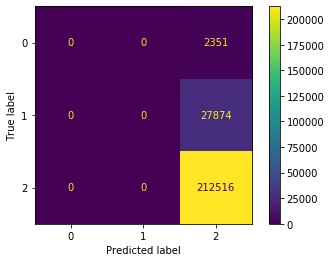

In [153]:
df_cars['Accident_Severity'].replace({1:0 , 2:1 , 3:2}, inplace=True)

# We prepare X and y
cars = df_cars.values
n,m = cars.shape

X = cars[:,0:m-1]
y = cars[:,m-1]

# We normalize X
X = StandardScaler().fit(X).transform(X)

# We make a partition of the X and y data, to have training and test data --> we use 20% of the data for test purposes and we take them randomly with shuffle = True
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)

# Let's verify that in the training set we have variety of data between 0 (fatal) and 2 (low severity)
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

# We create the logistic regression model for this multiclass case, and we train it 
clf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs').fit(X, y)

# We use the model to calculate the y_hat values
y_hat = clf.predict(X_test)
y_hat

# We calculate metrics: f1_score and accuracy:
print("Logistic regression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_hat))

# We display the confusion matrix for visibility:
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

#### 3.1.2. Logistic regression and decision tree: taking equilibrated subset of data

logisticRegression f1_score:  0.3312244750998459
logisticRegression Accuracy:  0.397037037037037


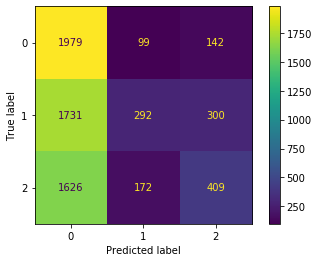

In [154]:
# We now just take a subset of the data so that we have now equilibrated amount of severity accidents between 0, 1 and 2
a = df_cars.loc[df_cars['Accident_Severity'] == 0]
b = df_cars.loc[df_cars['Accident_Severity'] == 1]
c = df_cars.loc[df_cars['Accident_Severity'] == 2]

a = a.sample(n = 7500)
b = b.sample(n = 7500)
c = c.sample(n = 7500)

new_cars = np.concatenate([a,b,c],axis=0)
n,m = new_cars.shape
X = new_cars[:,0:m-1]
y = new_cars[:,m-1]

# Logistic Regression
# We create the logistic regression model for this multiclass case, and we train it 
# We use the model to calculate the y_hat values
# We calculate metrics: f1_score
X = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)
clf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', class_weight={0:2,1:1,2:1}).fit(X, y)
y_hat = clf.predict(X_test)
print("logisticRegression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))

cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

#### 3.1.3. Logistic regression binarizing the Accident_Severity

In [ ]:
# We binarize Accident_Severity: fatal = 0, severe & slight = 1
df_cars['Accident_Severity'].replace({0:0 , 1:1 , 2:1}, inplace=True)
print(df_cars['Accident_Severity'].value_counts())

a = df_cars.loc[df_cars['Accident_Severity'] == 0]
b = df_cars.loc[df_cars['Accident_Severity'] == 1]

a = a.sample(n = 7500)
b = b.sample(n = 7500)

new_cars = np.concatenate([a,b],axis=0)
n,m = new_cars.shape
X = new_cars[:,1:m-1]
y = new_cars[:,m-1]
X = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)
clf = LogisticRegression(solver='lbfgs').fit(X, y)
y_hat = clf.predict(X_test)

print("logisticRegression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))
print("crossValidationScore: ", cross_val_score(clf, X, y, cv=3))

# Confusion matrix visualuzation
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

# y_hat_prob = clf.predict_proba(X_test)

# Learn to predict each class against the other
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve, ROC area and plot
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC logistic regression using binarized and balanced subset of data')
plt.legend(loc="lower right")
plt.show()

1    801525
0      7610
Name: Accident_Severity, dtype: int64
logisticRegression f1_score:  0.6339803162747862
logisticRegression Accuracy:  0.634
crossValidationScore:  [0.6238 0.6254 0.6262]


Note that, in general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

### 3.3. Decision tree

DecisionTrees's f1_score:  0.6335368592200469
DecisionTrees's Accuracy:  0.6353896103896104


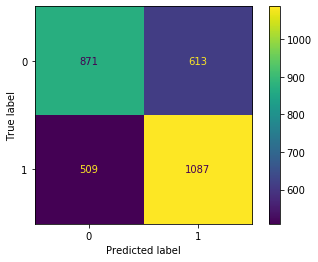

0.5855795148247979
0.681704260651629


In [56]:
# Decision tree
DT = tree.DecisionTreeClassifier(criterion="entropy")
DT = clf.fit(X_train,y_train)
print("DecisionTrees's f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("DecisionTrees's Accuracy: ", accuracy_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(DT, X_test, y_test)
plt.show()
cmfor0 = cm[0,0]/np.sum(cm[0,]); print(cmfor0)
cmfor1 = cm[1,1]/np.sum(cm[1,]); print(cmfor1)

### 3.4. Support Vector Machine (SVM)

SVM's f1_score:  0.6359037800687286
SVM's Accuracy:  0.637012987012987


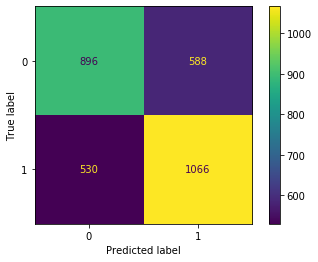

In [57]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print("SVM's f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("SVM's Accuracy: ", accuracy_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

In [58]:
print(df_cars.isna().sum())

Age_Band_of_Driver         0
Sex_of_Driver              0
Engine_Capacity_(CC)       0
Age_of_Vehicle             0
Light_Conditions           0
Road_Surface_Conditions    0
Urban_or_Rural_Area        0
Day_of_Week                0
Month                      0
1st_Point_of_Impact        0
Speed_limit                0
Accident_Severity          0
dtype: int64
